In [185]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import cv2 as cv
import datetime

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)


X_train = X_train.astype('float32') # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255 # normalize 
X_test /= 255

In [5]:
# one-hot format classes

nb_classes = 10 # number of unique digits

y_train = tf.one_hot(y_train, nb_classes)
y_test = tf.one_hot(y_test, nb_classes)

y_test.shape
y_train.shape

2022-07-10 22:00:37.383275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 22:00:37.387495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/karol/.local/lib/python3.9/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-07-10 22:00:37.387986: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping re

TensorShape([60000, 10])

In [6]:
zoom_range=(1,2) # define zoom range
# Create ImageDataGenerator training instance with data augmentation
train_datagen = ImageDataGenerator(width_shift_range=(0.08, 2), # shift the image width ways
                                   height_shift_range=(0.08, 2) ) # shift the image height ways

valid_datagen = ImageDataGenerator()

In [7]:
# define number of rows & columns
num_row = 2
num_col = 8
num = num_row*num_col

TRAIN:



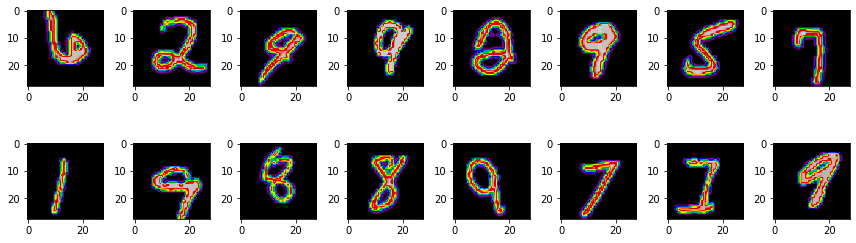

In [8]:
print('TRAIN:\n')
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for X, Y in train_datagen.flow(X_train ,y_train):
     for i in range(0, num):
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='nipy_spectral')
     break
plt.tight_layout()
plt.show()

In [9]:
train_generator = train_datagen.flow(X_train, y_train)
test_generator = valid_datagen.flow(X_test, y_test)

In [327]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1))),
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')),
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')),

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [325]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 25, 25, 64)        1088      
                                                                 
 conv2d_38 (Conv2D)          (None, 25, 25, 64)        65600     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 12, 12, 32)        18464     
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 flatten_8 (Flatten)         (None, 4608)              0         
                                                      

In [326]:
#save model after evry epoch
checkpoint=tf.keras.callbacks.ModelCheckpoint("models/model-{epoch:02d}-{val_accuracy:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint]

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator,  steps_per_epoch=60000//128, epochs=10, callbacks=callbacks_list)

Epoch 1/10
468/468 [==============================] - 26s 55ms/step - loss: 0.3548 - accuracy: 0.8869 - val_loss: 0.0890 - val_accuracy: 0.9703
Epoch 2/10
468/468 [==============================] - 25s 53ms/step - loss: 0.1057 - accuracy: 0.9661 - val_loss: 0.0628 - val_accuracy: 0.9810
Epoch 3/10
468/468 [==============================] - 24s 52ms/step - loss: 0.0842 - accuracy: 0.9746 - val_loss: 0.0474 - val_accuracy: 0.9854
Epoch 4/10
468/468 [==============================] - 25s 54ms/step - loss: 0.0772 - accuracy: 0.9750 - val_loss: 0.0417 - val_accuracy: 0.9869
Epoch 5/10
468/468 [==============================] - 27s 58ms/step - loss: 0.0607 - accuracy: 0.9791 - val_loss: 0.0316 - val_accuracy: 0.9909
Epoch 6/10
468/468 [==============================] - 28s 59ms/step - loss: 0.0547 - accuracy: 0.9823 - val_loss: 0.0377 - val_accuracy: 0.9865
Epoch 7/10
468/468 [==============================] - 25s 54ms/step - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.0360 - val_accuracy:

Text(0.5, 0, 'epochs')

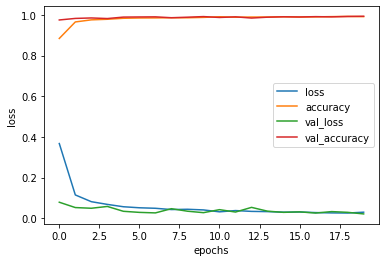

In [317]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [309]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0285 - accuracy: 0.9917


[0.028516730293631554, 0.9916999936103821]

In [191]:
model.save("model.h5")

In [287]:
def prepare_box(img):
    img = np.array(img)
    img = img[10:82, 10:82]
    mean = img.mean()
    if mean > 250:
        return img
    non_empty_columns = np.where(img.min(axis=1)<mean)[0]
    non_empty_rows = np.where(img.min(axis=1)<mean)[0]
    bb = (min(non_empty_rows)-4, max(non_empty_rows)+4, min(non_empty_columns)+4, max(non_empty_columns)+4)
    img = cv.bitwise_not(img)
    img = img[bb[0]:bb[1], bb[2]:bb[3]] 
    img = cv.resize(img, (28, 28))
    
    return bb

def cb(img):
    mean = img.mean()
    non_empty_columns = np.where(img.min(axis=1)<mean)[0]
    non_empty_rows = np.where(img.min(axis=1)<mean)[0]
    bb = (min(non_empty_rows)-4, max(non_empty_rows)+4, min(non_empty_columns)+4, max(non_empty_columns)+4)
    print(bb)
    return bb

def pred_and_plot(img_path, model_path):
    model = tf.keras.models.load_model(model_path)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 3, 1)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1)
    plt.imshow(img)
    plt.axis(False)
    fig.add_subplot(1, 3, 2)
    img = np.array(img)
    img = img[20:102, 20:102]
    img1 = img
    bb = cb(img1)
    plt.imshow(img1)
    plt.plot([bb[2], bb[3], bb[3], bb[2], bb[2]],
            [bb[0], bb[0],bb[1], bb[1], bb[0]],
            "r-")
    plt.axis(False)
    img = img[bb[0]:bb[1], bb[2]:bb[3]] 
    img = cv.bitwise_not(img)
    img = cv.resize(img, (28,28))
    fig.add_subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis(False)
    img = tf.expand_dims(img, 0)
    plt.title(np.argmax(model.predict(img)))

    plt.axis(False)
    plt.colorbar;
    


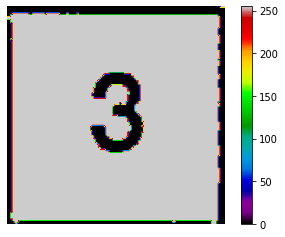

In [275]:
img = tf.io.read_file("box62.png")
img = tf.image.decode_image(img, channels=1)
plt.imshow(img, cmap="nipy_spectral")
plt.colorbar()
plt.axis(False);

(-4, 11, 4, 11)


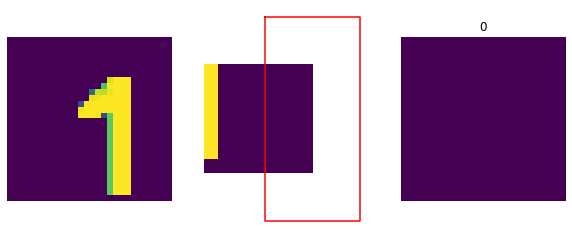

In [302]:
pred_and_plot("box51.png", "models/model-08-0.99.h5")